In [ ]:
'''
The following implementation of an NLP Neural machine translation model is based on the Tensorflow tutorial available at:
https://www.tensorflow.org/text/tutorials/nmt_with_attention  (Itself based on Effective Approaches to Attention-based 
Neural Machine Translation (Luong et al., 2015))

The tutorial was accessed on 11/12/2022
'''

In [ ]:
#!pip install "tensorflow-text>=2.10"
#!pip install einops
#!pip install matplotlib

In [1]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.translate.bleu_score import corpus_bleu

In [2]:
sentence = []
train=[]
train_source = open('train-source.txt', 'r', encoding='utf8')
for line in train_source:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    train.append(sentence)
  elif (token == '<s>'):
    sentence=[]
train_source_raw=[' '.join(elements) for elements in train]
train_source_raw = np.array(train_source_raw)

In [3]:
sentence = []
target=[]
train_target = open('train-target.txt', 'r', encoding='utf8')
for line in train_target:
  token = line.rstrip("\n")
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    target.append(sentence)
  elif (token == '<s>'):
    sentence=[]
train_target_raw=[' '.join(elements) for elements in target]
train_target_raw = np.array(train_target_raw)

In [4]:
is_train = np.random.uniform(size=(len(train_source_raw),)) < 0.8

In [5]:
len(is_train)

45171

In [6]:
BUFFER_SIZE = len(train_source_raw)
BATCH_SIZE = 8
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_raw[is_train], train_target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_raw[~is_train], train_target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [7]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [8]:
max_vocab_size = 10000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [9]:
context_text_processor.adapt(train_raw.map(lambda train_source_raw, target: train_source_raw))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'a', 'an', ',', 'agus', 'ar']

In [10]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [11]:
target_text_processor.adapt(train_raw.map(lambda train_source_raw, target: train_target_raw))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'a', 'an', ',', 'agus', 'ar']

In [12]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [13]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   74   24   48   13 1282   24 2421   33    7]

[   2   79   25   48   14 1150   25 2440   34    7]
[  79   25   48   14 1150   25 2440   34    7    6]


In [14]:
UNITS = 128

In [15]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [16]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (8, 48)
Encoder output, shape (batch, s, units): (8, 48, 128)


In [17]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (8, 48, 128)
Target sequence, shape (batch, t, units): (8, 45, 128)
Attention result, shape (batch, t, units): (8, 45, 128)
Attention weights, shape (batch, t, s):    (8, 45, 48)


In [19]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 1.0000001 , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

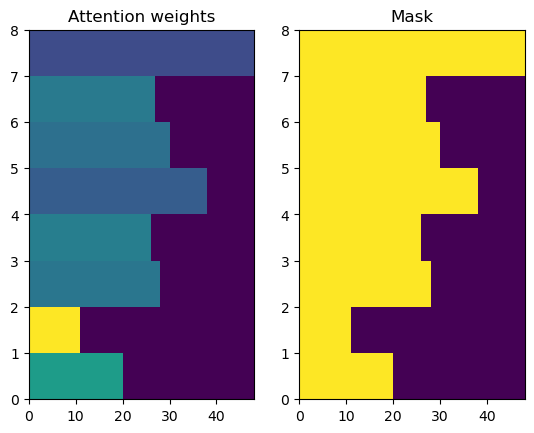

In [20]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [21]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [22]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  


  # 1. Lookup the embeddings
  x = self.embedding(x)
  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)

  if return_state:
    return logits, state
  else:
    return logits

In [23]:
decoder = Decoder(target_text_processor, UNITS)
logits = decoder(ex_context, ex_tar_in)

In [24]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [25]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [26]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [27]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'ndoire glasseile altu pheadar craith fiuntacha ghob goilleadh iomad ramhai',
       b'mhoirteil moran suimineacht bhac muirbhfeadh ghainimh shliabh giollai dheise spiorad',
       b'bhanu tionontaithe ceall chaora dtogfa chlai eadochais phoitin chorda [UNK]'],
      dtype=object)

In [28]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [29]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (8, 48)
Target tokens, shape: (batch, t) (8, 45)
logits, shape: (batch, t, target_vocabulary_size) (8, 45, 10000)


In [30]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [31]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [32]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [33]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [34]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 33ms/step - loss: 9.2127 - masked_acc: 3.4483e-04 - masked_loss: 9.2127


{'loss': 9.212669372558594,
 'masked_acc': 0.00034482759656384587,
 'masked_loss': 9.212669372558594}

In [35]:
history = model.fit(
    train_ds.repeat(), 
    epochs=25,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/25
100/100 [==============================] - 11s 45ms/step - loss: 6.6070 - masked_acc: 0.0734 - masked_loss: 6.6070 - val_loss: 6.0647 - val_masked_acc: 0.1256 - val_masked_loss: 6.0647
Epoch 2/25
100/100 [==============================] - 4s 44ms/step - loss: 5.6663 - masked_acc: 0.1549 - masked_loss: 5.6663 - val_loss: 5.5062 - val_masked_acc: 0.1720 - val_masked_loss: 5.5062
Epoch 3/25
100/100 [==============================] - 4s 43ms/step - loss: 5.3185 - masked_acc: 0.2035 - masked_loss: 5.3185 - val_loss: 5.0971 - val_masked_acc: 0.2249 - val_masked_loss: 5.0971
Epoch 4/25
100/100 [==============================] - 4s 44ms/step - loss: 5.0607 - masked_acc: 0.2269 - masked_loss: 5.0607 - val_loss: 4.8881 - val_masked_acc: 0.2545 - val_masked_loss: 4.8881
Epoch 5/25
100/100 [==============================] - 4s 43ms/step - loss: 4.7413 - masked_acc: 0.2700 - masked_loss: 4.7413 - val_loss: 4.6232 - val_masked_acc: 0.2869 - val_masked_loss: 4.6232
Epoch 6/25
100/100 [====

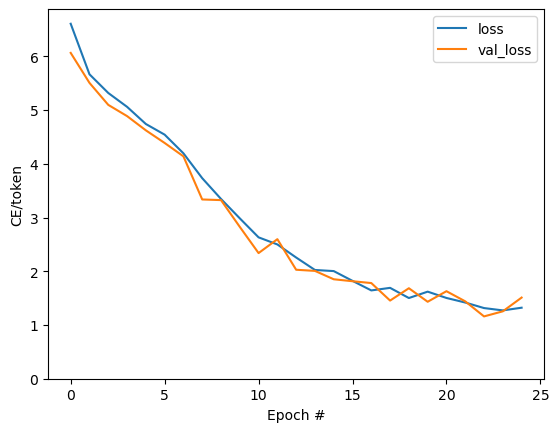

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

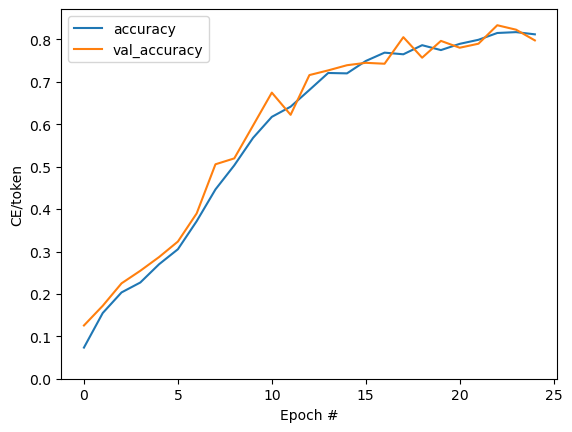

In [37]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [38]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [39]:
result = model.translate(['bhi muid ag cuartu agus ag breathnu ni ba ghrinne anois agus fuair'])
result[0].numpy().decode()

'bhi muid ag [UNK] agus ag [UNK] ni ba [UNK] anois agus fuair '

In [40]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\coryj\AppData\Local\Temp\ipykernel_8968\3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\coryj\AppData\Local\Temp\ipykernel_8968\3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


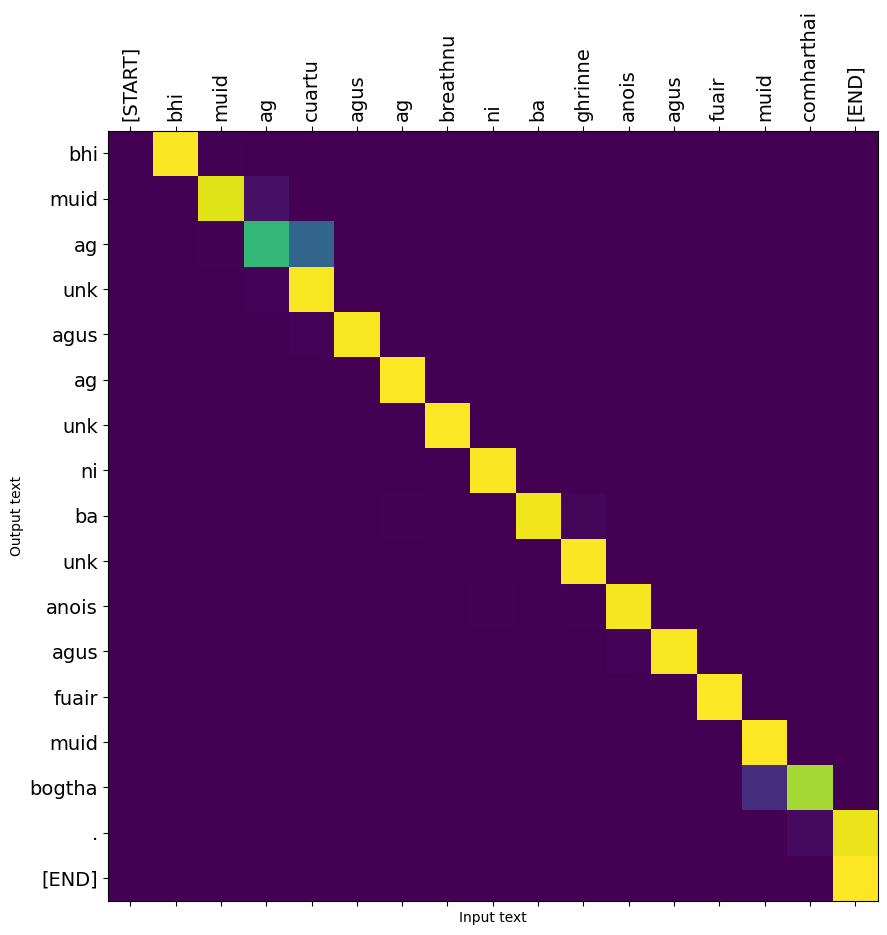

In [41]:
model.plot_attention('bhi muid ag cuartu agus ag breathnu ni ba ghrinne anois agus fuair muid comharthai') 

In [42]:
from unidecode import unidecode
sentence = []
target=[]
test_target = open('test-target.txt', 'r', encoding='utf8')
for line in test_target:
  token = unidecode(line.rstrip("\n").lower())
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    target.append(sentence)
  elif (token == '<s>'):
    sentence=[]
test_target_raw=[' '.join(elements) for elements in target]
test_target_raw = np.array(test_target_raw)

In [43]:
sentence = []
source=[]
test_source = open('test-source.txt', 'r', encoding='utf8')
for line in test_source:
  token = unidecode(line.rstrip("\n").lower())
  if (token != '<s>') and (token != '</s>'):
    sentence.append(token)
  elif token == '</s>':
    source.append(sentence)
  elif (token == '<s>'):
    sentence=[]
test_source_raw=[' '.join(elements) for elements in source]
test_source_raw = np.array(test_source_raw)

In [44]:
predicted=[]
actual=[]
for i in range(len(test_source_raw)):
    prediction = model.translate([test_source_raw[i]])
    prediction = prediction[0].numpy().decode()
    predicted.append(prediction)
    target_vals=test_target_raw[i]
    #target_vals=target_vals[0].numpy().decode()
    actual.append(target_vals)

In [45]:
print(predicted)

['sceal chathail aoidin binn mo dhearthair chun na [UNK] . ', 'mi [UNK] a bhi ann i bhfolach a , nuair a bhain an fear seo duinn . ', 'an dearthair ba sine agam , sean sinte , tugadh uainn go tobann e , agus a dhrabhlais no a [UNK] ni raibh againn le fail . ', 'trathnona brea amhain , chuaigh se a sheilg agus ach oiread agus da [UNK] an talamh e , nior phill se . ', 'bhi se go maith i na haite agus nuair a bhi muid ag ar ar na rosa bhi se lan grinn agus is choinnigh se an chuid a cinn againn i [UNK] a [UNK] orthu i [UNK] . ', 'iomlan na rudai a tharla an la sin , ta siad chomh soileir i mo shui is da mbeinn ag amharc orthu le mo dha shuil . ', 'tim go foill an [UNK] agus an [UNK] a chuireadh se ar a aghaidh nuair nach mbiodh mathair ag amharc agus an aire leis na gaire . ', 'bhi se i ndiaidh a theacht chun an bhaile ar laetha saoire is [UNK] na [UNK] agus bhi faoi am maith a bheith aige a bheith aige a bheith aige a bheadh se sa bhaile . ', 'mo dhuine bocht ! ', 'is beag a bhi a fhios 

In [46]:
print(actual)

['sceal chathail freeman - teann mo dhearthair chun na ducharraige', 'mi iuil a bhi ann i mbliain a 1854 , nuair a bhain an taisme seo duinn .', 'an dearthair ba sine agam , sean freeman , tugadh uainn go tobann e , agus a thasc na a thuairisc ni raibh againn le fail .', "trathnona brea amhain , chuaigh se a dh'iascaireacht ; agus , ach oiread agus da slogadh an talamh e , nior phill se .", "bhi se go maith ina shlainte agus nuair a bhi muid ag ar ndinnear bhi se lan grinn agus cuideachta ; agus choinnigh se an chuid ab oige againn i dtrithi gairi go dti go mb'eigean do m'athair bagairt orainn agus cuireadh fear de mo chuid dearthaireacha amach as an tseomra .", 'iomlan na rudai a tharla an la sin , ta siad chomh soileir i mo chuimhne is da mbeinn ag amharc orthu le mo dha shuil .', "tim go foill an caimbeal agus an anchuma a chuireadh se ar a aghaidh nuair nach mbiodh m'athair ag amharc agus d'fhagtai muidne sioctha leis na gairi .", 'bhi se i ndiaidh a theacht chun an bhaile ar laeth

In [47]:
print(corpus_bleu(actual,predicted, weights = [1])) 

0.1671726159321679
